#Andy Xiong and Julian Singer AI final assignment
Note!! you need to pay and use high ram or something because 12gb of ram is cutting it very close and crashes often

# Training a character language model and studying various ways of generating text

**Author: matthieu.labeau@telecom-paris.fr**

## Objectives:

- We will train a network to predict a next character given an input sequence of characters, and use it to generate new sequences.
- We will strictly work with local (and not structured) prediction - however, we will look into relatively simple heuristics to improve the "structure" of our generation: *temperature* sampling, *beam search*, *top-k* sampling, *top-p* sampling, drop-out input data.
- We will use ```keras```to build the model based on a LSTM, which will use simple features (one-hot vector representing previous characters) to predict the next characters. We will use a small model to avoid training for too long.
- We will use a small dataset (poetry, from project Gutenberg) - you can use any data you prefer, as long as you are able to train the model on it.
- Even with a small dataset and a small model, training may be long (~1 min/epoch on GPU). If you can use a computing infrastructure, like Google colab, it may be more practical - and you probably can obtain better results by using a bigger model and a larger dataset.  

In [ ]:
import numpy as np
import random
import sys
import matplotlib.pyplot as plt

### Obtaining the data
- We download directly the ebook from project Gutenberg - you can get any other text you would prefer.

In [ ]:
from keras.utils import get_file
url = 'https://www.gutenberg.org/cache/epub/100/pg100.txt'
path = get_file('pg100.txt', origin=url)

f = open(path, 'r' , encoding = 'utf8')
lines = f.readlines()
text = []

start = False
for line in lines:
    line = line.strip().lower() # Remove blanks and capitals
    if("*** START OF THE PROJECT GUTENBERG EBOOK THE COMPLETE WORKS OF WILLIAM SHAKESPEARE ***".lower() in line and start==False):
        start = True
    if("*** END OF THE PROJECT GUTENBERG EBOOK THE COMPLETE WORKS OF WILLIAM SHAKESPEARE ***".lower() in line):
        break
    if(start==False or len(line) == 0):
        continue
    text.append(line)

f.close()
text = " ".join(text)
voc_chars = sorted(set([c for c in text]))
nb_chars = len(voc_chars)

5638701/5638701 [==============================] - 1s 0us/step


In [ ]:
print(lines[0])

﻿The Project Gutenberg eBook of The Complete Works of William Shakespeare



### Keeping track of possible characters
- Using a ```set```, create a sorted list of possible characters
- Create two dictionnaries, having characters and corresponding indexes as {key: value}, and reverse.

Example:

```python
chars = [a, b, c]
```

```python
chars_indices = {a: 0, b: 1, c: 2}
```

```python
indices_chars = {0: a, 1: b, 2: c}
```

In [ ]:
print('Corpus length:', len(text))

chars = voc_chars
print('Total number of characters:', len(chars))
char_indices = {char: idx for idx, char in enumerate(chars)}
indices_char = {idx: char for idx,char in enumerate(chars)}

Corpus length: 5300294
Total number of characters: 69


#### Parenthesis: looking at words

- Try to look at tokenization schemes: what are the most frequent words if we use *whitespace* tokenization ?
- What are the most frequent words in this dataset using smarter tokenization ? You can a tokenizer from NLTK: ```nltk.word tokenize```.
- Make a plot of rank vs. word count. Does Zipf's Law seem to hold ?


In [ ]:
from collections import Counter
# Apply whitespace tokenization
tokens = text.split()

# Get frequencies and sort words according to them
freq = Counter(tokens)
ordered_word_list = [word for word, count in freq.most_common()]
print(ordered_word_list[:100])


del tokens
del freq
del ordered_word_list

['the', 'and', 'i', 'to', 'of', 'a', 'my', 'in', 'that', 'you', 'is', 'with', 'not', 'for', 'his', 'your', 'be', 'he', 'but', 'this', 'it', 'as', 'have', 'thou', 'me', 'will', 'thy', 'so', 'what', 'by', 'if', 'shall', 'her', 'all', 'do', 'are', 'we', 'him', 'our', 'no', 'on', 'from', 'good', 'at', 'they', 'or', 'she', 'would', 'their', 'which', 'enter', 'was', 'let', 'am', 'when', 'how', 'hath', 'than', 'more', 'thee', 'i’ll', 'an', 'like', 'king', 'upon', 'now', 'make', 'you,', 'then', 'may', 'should', 'did', 'were', 'one', 'must', 'scene', 'had', 'such', 'know', '’tis', 'yet', 'there', 'me,', 'love', 'come', 'here', 'some', 'them', 'sir,', 'give', 'these', 'where', 'see', 'go', 'take', 'o', 'can', 'most', 'say', 'first']


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk import word_tokenize
tokens = nltk.word_tokenize(text)

freq = Counter(tokens)
ordered_word_list = [word for word, count in freq.most_common()]
print(ordered_word_list[:20])

[',', '.', 'the', 'and', '’', 'i', 'to', 'of', 'a', 'you', 'my', ';', 'in', 'that', '?', 'is', 'not', 's', 'with', 'me']


In [ ]:
# Create an array containing the word rank in the first dimension, and its count in the second.
rank_counts = np.array([(rank, freq.get(word)) for rank, word in enumerate(ordered_word_list)])

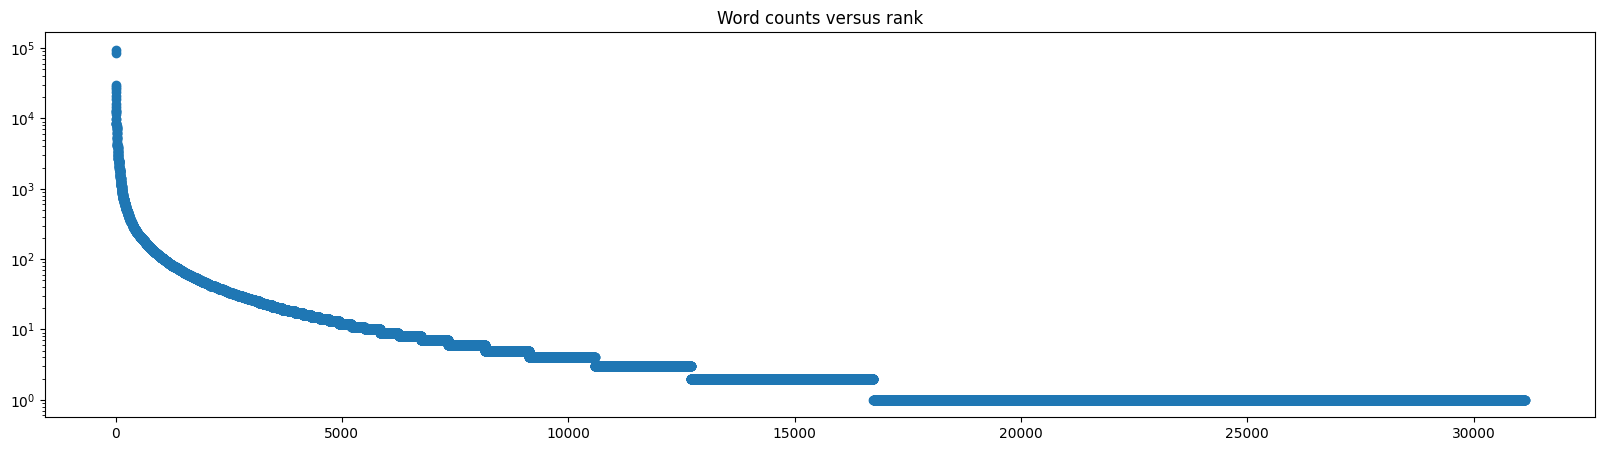

Vocabulary size: 31129
Part of the corpus by taking the "x" most frequent words:
1000 : 0.83
2000 : 0.89
3000 : 0.92
4000 : 0.94
5000 : 0.95
6000 : 0.96
7000 : 0.96
8000 : 0.97
9000 : 0.97
10000 : 0.97
11000 : 0.98
12000 : 0.98
13000 : 0.98
14000 : 0.98
15000 : 0.99
16000 : 0.99
17000 : 0.99
18000 : 0.99
19000 : 0.99
20000 : 0.99
21000 : 0.99
22000 : 0.99
23000 : 0.99
24000 : 0.99
25000 : 1.00
26000 : 1.00
27000 : 1.00
28000 : 1.00
29000 : 1.00
30000 : 1.00
31000 : 1.00


In [ ]:
plt.figure(figsize=(20,5))
plt.title('Word counts versus rank')
plt.scatter(rank_counts[:,0], rank_counts[:,1])
plt.yscale('log')
plt.show()

print('Vocabulary size: %i' % len(freq))
print('Part of the corpus by taking the "x" most frequent words:')
for i in range(1000, len(freq), 1000):
    print('%i : %.2f' % (i, np.sum(rank_counts[:i, 1]) / np.sum(rank_counts[:,1]) ))

del tokens
del freq
del ordered_word_list
del rank_counts

### Creating a model: a first, simple version

This model will take as input **a fixed number of characters** and output the next one. We will treat the model as a *black box* and leave its innner working for later.

#### Creating training data
- We will represent characters using *one-hot vectors*. Hence, the i-th character of n possible characters will be represented by a vector of length $n$, containing $0$ expect for a $1$ in position $i$. Following our previous examples, ```a = [1, 0, 0]``` and ```b = [0, 1, 0]```.
- Hence, a sequence of characters is a list of one-hot vectors. Our goal will be to predict, given an input sequence of fixed length (here, this length is given by ```maximum_seq_length```) the next character. Hence, we need to build two lists: ```sentences```, containing the input sequences, and ```next_char``` the characters to be predicted.
- We do not necessarily need to take all possible sequences. We can select one every ```time_step``` steps.

Example: Using the previous dictionnaries, the sequence:
```'acabbaccaabba'``` with ```maximum_seq_length = 4``` and ```time_step = 2``` would give the following lists:

```python
sentences = ['acab', 'abba', 'bacc', 'ccaa', 'aabb']
```

```python
next_char = ['b', 'c', 'a', 'b', 'a']
```

In [ ]:
maximum_seq_length = 30
time_step = 4
sentences = []
next_char = []
#we need to make sure we pick every time_step and stop when there are <=max_seq_length characters remaining
for i in range(0,len(text)-maximum_seq_length,time_step):
    sentences.append(text[i:i+maximum_seq_length])
    next_char.append(text[i+maximum_seq_length])
print('Number of Sequences:', len(sentences))

Number of Sequences: 1325066


In [ ]:
print(sentences[-3:])
print(next_char[-3:])

['s to immure herself and not be', ' immure herself and not be see', 'ure herself and not be seen. f']
[' ', 'n', 'i']


#### Creating training tensors
- We need to transform these lists into tensors, using one-hot vectors to represent characters.
- We will need 3 dimensions for the training examples from ```sentences```: the number of examples, the length of the sequence, and the dimension of the one-hot vector
- This is reduced to 2 dimensions for the ```next_char```: number of examples and one-hot vector.

Example: the previous ```sentences``` would become:

```python
X = [[[1, 0, 0],
      [0, 0, 1],
      [1, 0, 0],
      [0, 1, 0]],
     [[1, 0, 0],
      [0, 1, 0],
      [0, 1, 0],
      [1, 0, 0]],
     [[0, 1, 0],
      [1, 0, 0],
      [0, 0, 1],
      [0, 0, 1]],
     [[0, 0, 1],
      [0, 0, 1],
      [1, 0, 0],
      [1, 0, 0]],
     [[1, 0, 0],
      [1, 0, 0],
      [0, 1, 0],
      [0, 1, 0]]]
```
       
```python
y = [[0, 1, 0],
     [0, 0, 1],
     [1, 0, 0],
     [0, 1, 0],
     [1, 0, 0]]
```

In [ ]:
X = np.zeros((len(sentences), maximum_seq_length, len(chars)), dtype=bool)
y = np.zeros((len(sentences), len(chars)), dtype=bool)
# Loop over the sentences
for i, phrases in enumerate(sentences):
    # Loop over the characters
    for j, characters in enumerate(phrases):
        # Put the right value of X to 1
        idx = char_indices.get(characters)
        X[i][j][idx] = 1
    # Put the right value of y to 1
    idx = char_indices.get(next_char[i])
    y[i][idx] = 1

#### Implement the model

In order to implement the model as simply as possible, we will use ```keras```. It allows to create models with only a few lines of code.
First, we will create a very simple model based on a **LSTM**, which is a *recurrent* architecture. Note that one the strength of a recurrent architecture is to allow for inputs of varying length - here, to simplify data processing, we will keep a **fixed input size**.

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Embedding
from keras.layers import LSTM
from keras.callbacks import LambdaCallback, EarlyStopping
from keras.metrics import sparse_categorical_crossentropy

We need to create a LSTM model that takes directly out inputs from ```X``` and try to predict one-hot vectors from ```y```.
- What are the input and output dimensions ?
  - ```X```: size of the dataset $\times$ maximum sequence length $\times$ vocabulary size
  - ```y```: size of the dataset $\times$ vocabulary size
- The model should be made with a ```LSTM``` layer, and a ```Dense``` layer followed by a softmax activation function. Work out the intermediate dimensions:
  - ```X``` $\rightarrow$ (LSTM) $\rightarrow$ ```h``` $\rightarrow$ (Dense) $\rightarrow$ ```s``` $\rightarrow$ (softmax) $\rightarrow$ ```pred```
  - Look at layers arguments and find out to proper ```input_shape``` for the ```LSTM``` layer and the proper size for the ```Dense``` layer.
  - You can use 128 as the size of hidden states for the ```LSTM```.
- We will minimize ```cross-entropy(pred, y)```. Use the ```categorical_crossentropy``` loss, with the optimizer of your preference (for example, ```adam```).

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(maximum_seq_length, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

You will now only need a few functions to use this model:
- ```model.fit```, which you will call on the appropriately processed data ```X, y```
- ```model.predict```, which you will use on an input **of the same dimension of X** to output the probabilities. That includes the *first one*, corresponding to the number of examples in the input.

### Create functions to generate text with our model
- We use the output of our model (vector of probabilities on characters) to select the next most probable character (with the ```argmax```)
- We need to transform an input text into an input tensor, as before (taking the right length, the last ```maximum_seq_length``` characters)
- We need to transform back the most probable index into a character and add it to our text.
- This must be looped ```num_generated``` times, each time obtaining a new input tensor from the new input sequence (which has the character we previously predicted at the end !)

We can begin to write a function facilitating the transfer between text and tensors:

In [ ]:
#From my understanding we just take a sentence "hello world" and convert it to 0 and 1s
def get_tensor(sentence, maximum_seq_length, voc):
    x = np.zeros((1, maximum_seq_length, len(voc)))
    # Fill out x appropriately
    for i, characters in enumerate(sentence):
      if i >= maximum_seq_length:
        break
      idx = voc.get(characters)
      x[0][i][idx] = 1

    return x

In [ ]:
text_ex = "From fairest creatures we desire increase,"
get_tensor(text_ex.lower(), 30, char_indices).shape

(1, 30, 69)

You have now what is necessary to fill out ```generate_next```.

The following function (```end_epoch_generate```) is here to facilitate automatic generation at the end of each epoch, so you can monitor of generation changes as the model trains. It calls the ```generate_next``` function upon each sequence of text in ```texts_ex```. The only element in this list right now comes from the training data - you can add your own. We also use ```EarlyStopping``` to stop training when validation loss does not decrease.

In [ ]:
def generate_next(model, text, num_generated=120):
    generated = text
    sentence = text[-maximum_seq_length:]
    for i in range(num_generated):
        # Obtain the representation for the sentence, the prediction, the index of the better character and the character itself.
        x = get_tensor(sentence, maximum_seq_length, char_indices)
        predictions = model.predict(x)
        next_index = np.argmax(predictions)
        next_char = indices_char.get(next_index)
        generated += next_char
        sentence = sentence[1:] + next_char
    return(generated)

def end_epoch_generate(epoch, _):
    print(' Generating text after epoch: %d' % (epoch+1))
    texts_ex = ["From fairest creatures we desire increase,"]
    for text in texts_ex:
        sample = generate_next(model, text.lower())
        print('%s' % (sample))

early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=2,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True
)

Test generation with the model not yet trained:

In [ ]:
text_ex = "From fairest creatures we desire increase,"
generate_next(model, text_ex.lower())

1/1 [==============================] - 0s 17ms/step


'from fairest creatures we desire increase,\tll5l55â566î8888ttt…!t![[[::æ…[[[[::æ…æ[[[[::æ…æ[[[::æ…æ[[[[::æ…[[[::ææ[[::æ…æ[[[[::æ…[[[::ææ[[::æ…æ[[[[::æ…[[[::ææ[[::æ'

In [ ]:
model.fit(X, y,
          batch_size=128,
          epochs=5,
          validation_split = 0.2,
          callbacks=[LambdaCallback(on_epoch_end=end_epoch_generate), early_stopping])

Epoch 1/5
1/1 [==============================] - 0s 20ms/step
from fairest creatures we desire increase, and the sear her the sear her the sear her the sear her the sear her the sear her the sear her the sear her the sear he
8282/8282 [==============================] - 50s 6ms/step - loss: 2.1261 - val_loss: 1.9686
Epoch 2/5
1/1 [==============================] - 0s 18ms/step
from fairest creatures we desire increase, and the stall the stall the stall the stall the stall the stall the stall the stall the stall the stall the stall the s
8282/8282 [==============================] - 46s 6ms/step - loss: 1.8349 - val_loss: 1.8417
Epoch 3/5
1/1 [==============================] - 0s 18ms/step
from fairest creatures we desire increase, and the proves and the proves and the proves and the proves and the proves and the proves and the proves and the proves
8282/8282 [==============================] - 46s 6ms/step - loss: 1.7193 - val_loss: 1.7735
Epoch 4/5
1/1 [==============================] - 

#### Sampling with our model
- Now, instead of simply selecting the most probable next character, we would like to be able to draw a sample from the distribution output by the model.
- To better control the generation, we would like to use the argument ```temperature```, to smooth the distribution.
- Use the ```multinomial``` function from the ```random``` package to draw samples.
- Integrate this into a function ```generate_sample``` that be almost exactly like ```generate_next```.

In [ ]:
def sample(predictions, temperature):
    # From the prediction, apply the temperature to reweights the probabilities and sample.
    predictions = np.asarray(predictions).astype('float64')
    log_predictions = np.log(predictions) / temperature
    predictions = np.exp(log_predictions)
    predictions = predictions / np.sum(predictions)
    probas = np.random.multinomial(1, predictions[0,:], 1) #the original code was throwing an error as pred is (1,69) not (69)
    return np.argmax(probas)


def generate_sample(model, text, num_generated=120, temperature=1.0):
    generated = text
    sentence = text[-maximum_seq_length:]
    for i in range(num_generated):
        x = get_tensor(sentence, maximum_seq_length, char_indices)
        predictions = model.predict(x)
        next_index = sample(predictions, temperature)
        next_char = indices_char.get(next_index)
        generated += next_char
        sentence = sentence[1:] + next_char
    return(generated)

In [ ]:
generate_sample(model, text_ex.lower(), temperature = 0.7)

1/1 [==============================] - 0s 20ms/step


'from fairest creatures we desire increase, here here, be ilser tome bring of men and for parthiage. [_exit a comes than a basber. dear i have her your fanching th'

#### Generate text with the beam algorithm
- Complete this function implementing the beam procedure.
- We need to loop for each character we want to generate, keeping track of the best ```beam_size``` sequences at the most.
- Besides keeping track of past generated character for each of these ```beam_size``` sequences, we need to keep track of their log-probability.
- This is done by, at each loop, keeping the ```beam_size```best predictions for each of the ```beam_size``` sequences, computing the log-probabilities of the newly formed (```beam_size```)$^2$ , and keeping the overall ```beam_size``` best new sequences.

In [ ]:
def generate_beam(model, text, beam_size=5, num_generated=120):
    generated = text
    sentence = text[-maximum_seq_length:]
    # Initialization of the beam with log-probabilities for the sequence
    current_beam = [(0, [], sentence)]

    for l in range(num_generated):
        all_beams = []
        for prob, current_preds, current_input in current_beam:
            x = get_tensor(current_input, maximum_seq_length, char_indices)
            prediction = model.predict(x)[0]
            # beam_size best predictions !
            #merge probabilities with the char index since we need to access both
            possible_next_chars = zip(np.argsort(prediction)[-beam_size:], np.sort(prediction)[-beam_size:])
            # Add to the beams: (the probability of the sequence, the sequence of indexes generated, the full sequence of characters)
            all_beams += [
                (prob + np.log(next_prob),
                 current_preds + [next_idx],
                 current_input[1:] + indices_char[next_idx]
                )
                for next_idx, next_prob in possible_next_chars]

        # Sort the beams according to their probability and keep the beam_size best
        current_beam = sorted(all_beams, key=lambda x: x[0], reverse=True)[:beam_size]

    #once we have the generated beam, take best sequence and then append it onto the text
    best_sequence = max(current_beam, key=lambda x: x[0])
    best_sentence = generated + ''.join([indices_char[idx] for idx in best_sequence[1]])

    return best_sentence



In [ ]:
generate_beam(model, text_ex.lower())

1/1 [==============================] - 0s 19ms/step


'from fairest creatures we desire increase, and thou art thou art thou art thou art thou art thou art thou art thou art thou art thou art thou art thou art that th'

#### Reranking
If we would like to use our outputs for a task, a common strategy is to generate a large number of them, and select the one that maximizes the relevant metric: this is **re-ranking**.

First, we need an evaluation measure. For now, we can use **perplexity**: given how cross-entropy is computed in ```keras```, perplexity is simply *the exponential of the mean cross-entropy over the sequence*.

To compute the cross-entropy, you need both the true ```y``` and the corresponding ```pred``` output by the model. While the most efficient would be to gather these while sampling, we can re-compute it for any sentence with the following function:

In [53]:
def get_preds(sentence):
    # Reconstitute the inputs and outputs from the sentence: first as list of characters
    eval_input = []
    eval_target = []
    for i in range(0, len(sentence) - maximum_seq_length):
        eval_input.append(sentence[i: i + maximum_seq_length])
        eval_target.append(sentence[i + maximum_seq_length])

    # Then as tensors
    eval_X = np.zeros((len(eval_input), maximum_seq_length, len(char_indices)))
    eval_y = np.zeros((len(eval_input), len(char_indices)))

    for i, sequence in enumerate(eval_input):
        for j, char in enumerate(sequence):
            if char in char_indices:
                eval_X[i, j, char_indices[char]] = 1
        next_char = eval_target[i]
        eval_y[i, char_indices[next_char]] = 1
    eval_pred = model.predict(eval_X)

    return eval_y, eval_pred

In [78]:
import tensorflow as tf
def perplexity(y_true, y_pred):
    #so this is the function we originally imported, but since it doesn't take one hot vectors we'll need to change it
    #cross_entropy = sparse_categorical_crossentropy(np.argmax(y_true), np.argmax(y_pred))
    #but for some reason the line above throws "Cannot convert 1e-07 to EagerTensor of dtype int64" so I'm just going to use something else
    cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    perplexity = np.exp(np.mean(cross_entropy))
    return perplexity

In [79]:
def re_rank(sentence):
    eval_y, eval_pred = get_preds(sentence)
    return perplexity(eval_y, eval_pred)

You can then generate a bunch of sentences, obtain their perplexity and sort them accordingly:

In [80]:
reranked = dict()
for k in np.arange(5,10):
    for t in np.arange(0.5, 1.0, 0.05):
        sentence = generate_sample(model, text_ex.lower(), k, temperature = 0.7)
        p = re_rank(sentence)
        reranked[sentence] = p

1/1 [==============================] - 0s 20ms/step


In [ ]:
print(sorted(reranked, key=reranked.get))

['from fairest creatures we desire increase, and th', 'from fairest creatures we desire increase, and ', 'from fairest creatures we desire increase, and brin', 'from fairest creatures we desire increase, and mak', 'from fairest creatures we desire increase, and m', 'from fairest creatures we desire increase, that i', 'from fairest creatures we desire increase, with ', 'from fairest creatures we desire increase, and be t', 'from fairest creatures we desire increase, in the s', 'from fairest creatures we desire increase, and f', 'from fairest creatures we desire increase, that no ', 'from fairest creatures we desire increase, the ', 'from fairest creatures we desire increase, for ', 'from fairest creatures we desire increase, and wer', 'from fairest creatures we desire increase, and bri', 'from fairest creatures we desire increase, i woul', 'from fairest creatures we desire increase, see the', 'from fairest creatures we desire increase, what', 'from fairest creatures we desire increase, 

In [51]:
print(reranked)

{'from fairest creatures we desire increase, my l': 4.1768384, 'from fairest creatures we desire increase, and ': 3.3702784, 'from fairest creatures we desire increase, what': 3.8979867, 'from fairest creatures we desire increase, to t': 4.2336335, 'from fairest creatures we desire increase, so f': 4.680103, 'from fairest creatures we desire increase, for ': 3.7724378, 'from fairest creatures we desire increase, the ': 3.74775, 'from fairest creatures we desire increase, know ': 4.4258204, 'from fairest creatures we desire increase, with ': 3.6908903, 'from fairest creatures we desire increase, fathe': 4.2948236, 'from fairest creatures we desire increase, from ': 3.9422836, 'from fairest creatures we desire increase, to pi': 4.84537, 'from fairest creatures we desire increase, and m': 3.6275628, 'from fairest creatures we desire increase, confe': 4.4080834, 'from fairest creatures we desire increase, and f': 3.7441967, 'from fairest creatures we desire increase, the y': 4.5739865, 'fr

In [ ]:
del X
del y
del model

### Create a second model: with embeddings (Optional)

This model will have a key difference with the previous one: we will use **dense embeddings** instead of one-hot representations.
This means that:
- In ```X```, we will use the index of the character instead of an one-hot vector. For example, the following ```['acab', 'abba', 'bacc', 'ccaa', 'aabb']``` will be represented as ```[[0, 2, 0, 1], [0, 1, 1, 0], [1, 0, 2, 2], [2, 2, 0, 0]]```.
- We will need another input layer before the LSTM. Instead of ```Dense```, keras has a dedicated layer: ```Embedding```.

Create the dataset, adapt the generation function, create the new model, and compare the results.

In [ ]:
X_emb = np.zeros(...)
y_emb = np.zeros(...)
for ...
    for ...
        ...
    ...

print('X_emb shape:', X_emb.shape)
print('y_emb shape:', y_emb.shape)

In [ ]:
from keras.layers import Embedding

In [ ]:
def generate_next_emb(model, text, num_generated=120):
    generated = text
    sentence = text[-maximum_seq_length:]
    char_idxs = [[char_indices[char] for char in sentence]]
    for i in range(num_generated):
        x = ...
        predictions = ...
        next_index = ...
        next_char = ...
        generated += next_char
        char_idxs = [char_idxs[0][1:] + [next_index]]
    return(generated)

def end_epoch_generate(epoch, _):
    print('\n Generating text after epoch: %d' % (epoch+1))
    texts_ex = ["From fairest creatures we desire increase,"]
    for text in texts_ex:
        sample = generate_next_emb(model_emb_m2m, text)
        print('%s' % (sample))

In [ ]:
model_emb_m2m = Sequential()
model_emb_m2m.add(...)
model_emb_m2m.add(LSTM(128, input_shape=(maximum_seq_length, 32), return_sequences=False))
model_emb_m2m.add(Dense(len(chars)))
model_emb_m2m.add(Activation('softmax'))

model_emb_m2m.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

In [ ]:
model_emb_m2m.fit(X_emb, y_emb,
                  batch_size=128,
                  epochs=5,
                  validation_split = 0.2,
                  callbacks=[LambdaCallback(on_epoch_end=end_epoch_generate)])

In [ ]:
generate_next_emb(model_emb_m2m, "From fairest creatures we desire increase,")

In [ ]:
def get_tensor_emb(sentence, maximum_seq_length, voc):
    x = ...
    return x

In [ ]:
def generate_sample_emb(model, text, num_generated=120, temperature=1.0):
    generated = text
    sentence = text[-maximum_seq_length:]
    for i in range(num_generated):
        x = ...
        predictions = ...
        next_index = sample_function(predictions, temperature)
        next_char =  ...
        generated += next_char
        sentence = sentence[1:] + next_char
    return(generated)

In [ ]:
generate_sample_emb(model_emb_m2m, text_ex.lower(), temperature = 0.7)